# 3. Exploratory Spatial Data Analysis (ESDA)

## Exploring Income distribution in Greater Sydney

Let's start by importing some required lybraries: pysal, pandas, and numpy.

In [8]:
import pysal as ps
import pandas as pd
import numpy as np

A well-used functionality in PySAL is the use of PySAL to conduct exploratory spatial data analysis. This notebook will provide an overview of ways to conduct exploratory spatial analysis in Python.

First, let's read in some data:

In [9]:
shp_link = '../data_geocomp/MeanIncome_PUR_SA1_2016_GSyd_UTM.shp' 
data = ps.pdio.read_files(shp_path)

In [10]:
data.head()

,SA1_MAIN16,SA1_7DIG16,SA2_MAIN16,SA2_5DIG16,SA2_NAME16,SA3_CODE16,SA3_NAME16,SA4_CODE16,SA4_NAME16,GCC_CODE16,GCC_NAME16,STE_CODE16,STE_NAME16,AREASQKM16,OID_,SA1_2016,Workers,MeanInc,geometry
0,10201102802,1102802,102011028,11028,Avoca Beach - Copacabana,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,1.1648,5927,1102802,609.0,960.120350,<pysal.cg.shapes.Polygon object at 0x000002B59...
1,10201102803,1102803,102011028,11028,Avoca Beach - Copacabana,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,0.5739,7283,1102803,614.0,1068.634259,<pysal.cg.shapes.Polygon object at 0x000002B59...
2,10201102804,1102804,102011028,11028,Avoca Beach - Copacabana,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,0.1519,6556,1102804,240.0,1005.104712,<pysal.cg.shapes.Polygon object at 0x000002B59...
3,10201102805,1102805,102011028,11028,Avoca Beach - Copacabana,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,0.1310,6047,1102805,330.0,968.991416,<pysal.cg.shapes.Polygon object at 0x000002B59...
4,10201102806,1102806,102011028,11028,Avoca Beach - Copacabana,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,0.2143,4119,1102806,528.0,831.666667,<pysal.cg.shapes.Polygon object at 0x000002B59...


In [13]:
import matplotlib.pyplot as plt

Then, let's have a look at the distribution of the variable 'Mean Income' in the study area. Does it follow a normal distribution?

(array([1., 0., 0., ..., 0., 0., 1.]),
 array([  70.3125    ,   72.43229167,   74.55208333, ..., 3245.76041667,
        3247.88020833, 3250.        ]),
 <a list of 1500 Patch objects>)

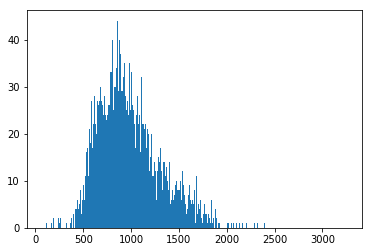

In [36]:
plt.hist(data.MeanInc, bins=1500)

In a normal distribution mean=median. If the distribution is positively skewed (long tail on the right side), the median is smaller than the mean; and if negatively skewed (long tail on the left), the median is larger than the mean.

Let'd check the mean and median for our variable of interest.

In [20]:
np.mean(data.MeanInc)

978.794365397436

In [22]:
np.median(data.MeanInc)

931.068944

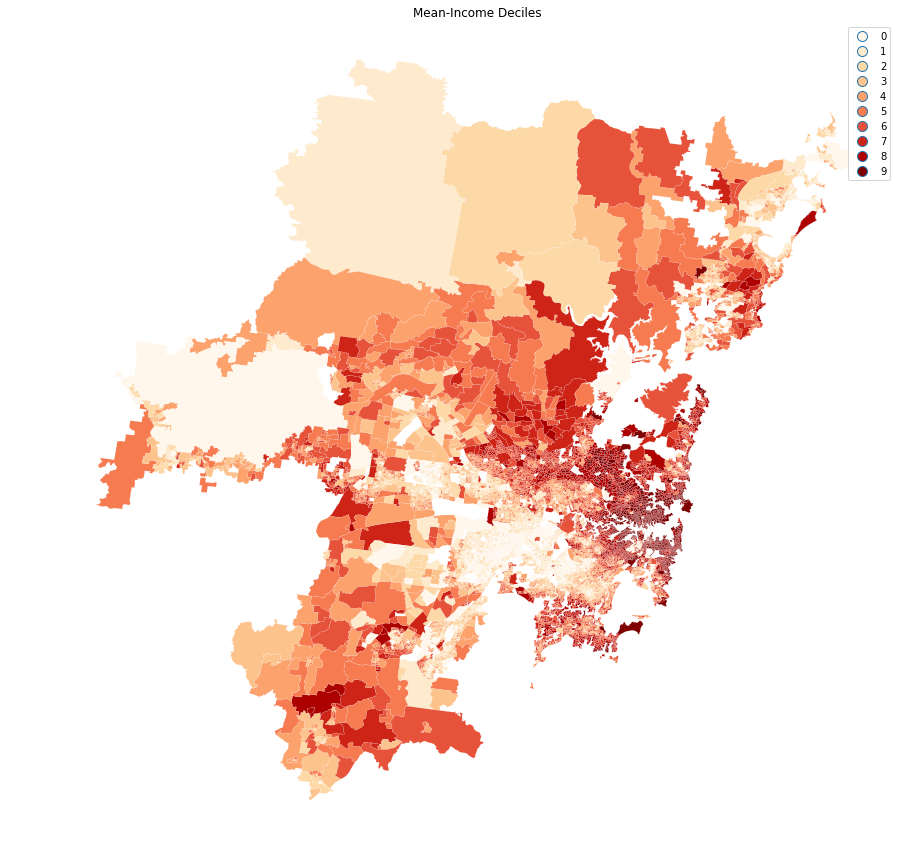

In [7]:
import geopandas as gpd 
tx = gpd.read_file(shp_link) 
mi10 = ps.Quantiles(data.MeanInc, k=10)
f, ax = plt.subplots(1, figsize=(15, 15))
tx.assign(cl=mi10.yb).plot(column='cl', categorical=True, \
        k=10, cmap='OrRd', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Mean-Income Deciles")
plt.show()

# Spatial Autocorrelation

Visual inspection of the map pattern for FH90 deciles allows us to search for spatial structure. If the spatial distribution of the rates was random, then we should not see any clustering of similar values on the map. However, our visual system is drawn to the darker clusters in the south west as well as the east, and a concentration of the lighter hues (lower homicide rates) moving north to the pan handle.

Our brains are very powerful pattern recognition machines. However, sometimes they can be too powerful and lead us to detect false positives, or patterns where there are no statistical patterns. This is a particular concern when dealing with visualization of irregular polygons of differning sizes and shapes.

The concept of spatial autocorrelation relates to the combination of two types of similarity: spatial similarity and attribute similarity. Although there are many different measures of spatial autocorrelation, they all combine these two types of simmilarity into a summary measure.

Let's use PySAL to generate these two types of similarity measures.

## Spatial Similarity

We have already encountered spatial weights in a previous notebook. In spatial autocorrelation analysis, the spatial weights are used to formalize the notion of spatial similarity. As we have seen there are many ways to define spatial weights, here we will use queen contiguity:

In [13]:
data = ps.pdio.read_files(shp_link)
W = ps.queen_from_shapefile(shp_link)
W.transform = 'r'

('WARNING: ', 287, ' is an island (no neighbors)')
('WARNING: ', 2999, ' is an island (no neighbors)')
('WARNING: ', 5561, ' is an island (no neighbors)')
('WARNING: ', 6297, ' is an island (no neighbors)')
('WARNING: ', 6760, ' is an island (no neighbors)')
('WARNING: ', 10591, ' is an island (no neighbors)')


C:\Users\Simone\Anaconda3\lib\site-packages\pysal\weights\weights.py:189: UserWarning: There are 6 disconnected observations
  warnings.warn("There are %d disconnected observations" % ni)
C:\Users\Simone\Anaconda3\lib\site-packages\pysal\weights\weights.py:190: UserWarning: Island ids: 287, 2999, 5561, 6297, 6760, 10591
  warnings.warn("Island ids: %s" % ', '.join(str(island) for island in self.islands))


## Attribute Similarity

So the spatial weight between counties $i$ and $j$ indicates if the two counties are neighbors (i.e., geographically similar). What we also need is a measure of attribute similarity to pair up with this concept of spatial similarity. The spatial lag is a derived variable that accomplishes this for us. For county $i$ the spatial lag is defined as: 

FH90Lag_i = \sum_j w_{i,j} FH90_j

In [16]:
miLag = ps.lag_spatial(W, data.MeanInc)

In [18]:
miLagQ10 = ps.Quantiles(miLag, k=10)

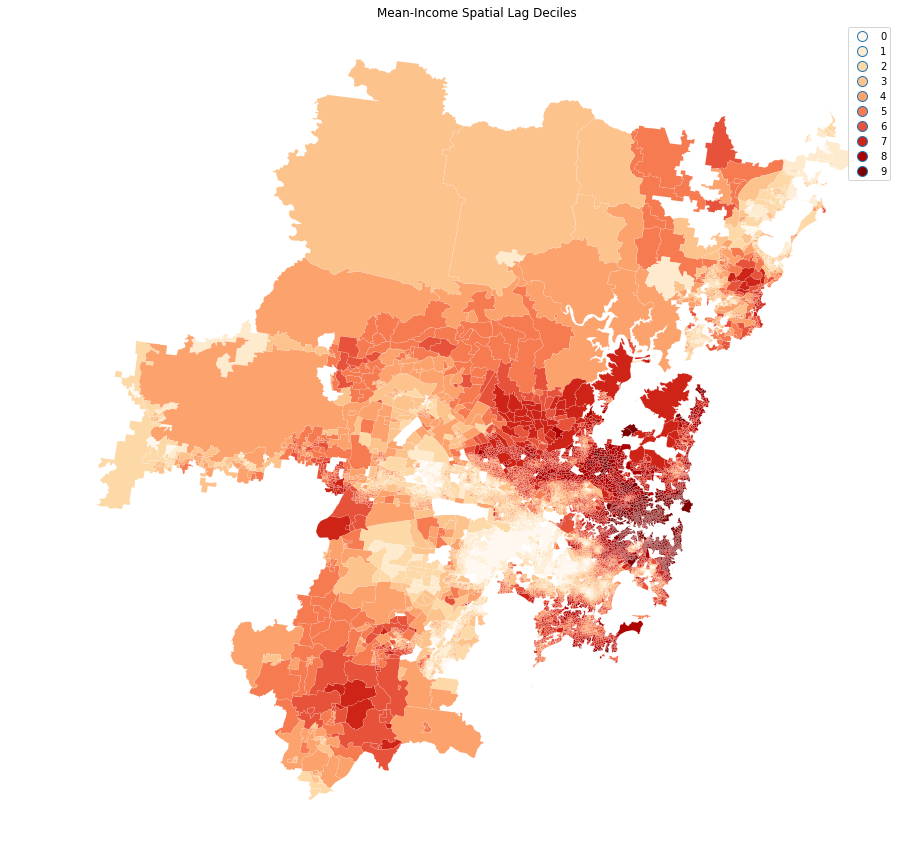

In [20]:
f, ax = plt.subplots(1, figsize=(15, 15))
tx.assign(cl=miLagQ10.yb).plot(column='cl', categorical=True, \
        k=10, cmap='OrRd', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Mean-Income Spatial Lag Deciles")

plt.show()

The decile map for the spatial lag tends to enhance the impression of value similarity in space. However, we still have the challenge of visually associating the value of the homicide rate in a county with the value of the spatial lag of rates for the county. The latter is a weighted average of homicide rates in the focal county's neighborhood.

To complement the geovisualization of these associations we can turn to formal statistical measures of spatial autocorrelation.

In [31]:
mi = data.MeanInc
b,a = np.polyfit(mi, miLag, 1)

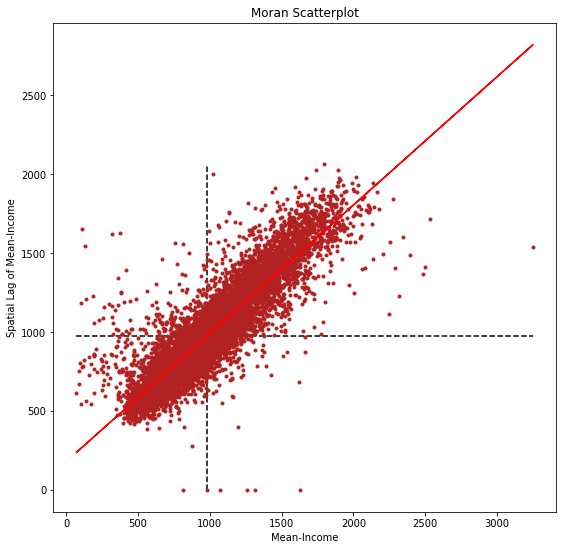

In [32]:
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(mi, miLag, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(mi.mean(), miLag.min(), miLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(miLag.mean(), mi.min(), mi.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(mi, a + b*mi, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Mean-Income')
plt.xlabel('Mean-Income')
plt.show()

# Global Spatial Autocorrelation

In PySAL, commonly-used analysis methods are very easy to access. For example, if we were interested in examining the spatial dependence in FH90 we could quickly compute a Moran's $I$ statistic:

In [41]:
I_mi = ps.Moran(data.MeanInc.values, W)

In [42]:
I_mi.I, I_mi.p_sim

(0.8147087579811264, 0.001)

Thus, the $I$ statistic is $0.557$ for this data, and has a very small $p$ value. 

We can visualize the distribution of simulated $I$ statistics using the stored collection of simulated statistics:

In [43]:
I_mi.sim[0:5]

array([-9.81272925e-03,  7.93484340e-03,  7.84644133e-04,  9.86739328e-05,
        3.85504751e-04])

A simple way to visualize this distribution is to make a KDEplot (like we've done before), and add a rug showing all of the simulated points, and a vertical line denoting the observed value of the statistic:

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

(-0.04, 0.04)

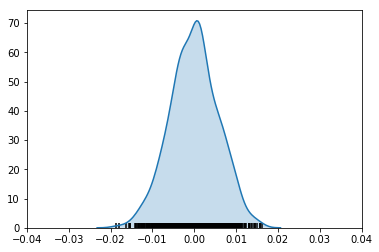

In [48]:
sns.kdeplot(I_mi.sim, shade=True)
plt.vlines(I_mi.sim, 0, 1.5)
plt.vlines(I_mi.I, 0, 70, 'r')
plt.xlim([-0.04, 0.04])

Instead, if our $I$ statistic were close to our expected value, I_HR90.EI, our plot might look like this:

(-0.04, 0.04)

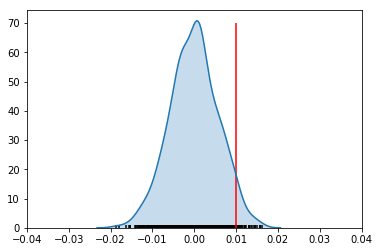

In [50]:
sns.kdeplot(I_mi.sim, shade=True)
plt.vlines(I_mi.sim, 0, 1)
plt.vlines(I_mi.EI+.01, 0, 70, 'r')
plt.xlim([-0.04, 0.04])

The result of applying Moran's I is that we conclude the map pattern is not spatially random, but instead there is a signficant spatial association in homicide rates in Texas counties in 1990.

This result applies to the map as a whole, and is sometimes referred to as "global spatial autocorrelation". Next we turn to a local analysis where the attention shifts to detection of hot spots, cold spots and spatial outliers.

# Local Autocorrelation Statistcs

In addition to the Global autocorrelation statistics, PySAL has many local autocorrelation statistics. Let's compute a local Moran statistic for the same data shown above:

In [51]:
LMo_mi = ps.Moran_Local(data.MeanInc.values, W)

C:\Users\Simone\Anaconda3\lib\site-packages\pysal\esda\moran.py:851: RuntimeWarning: invalid value encountered in true_divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
C:\Users\Simone\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Simone\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Simone\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1738: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


Now, instead of a single $I$ statistic, we have an array of local $I_i$ statistics, stored in the .Is attribute, and p-values from the simulation are in p_sim.

In [52]:
LMo_mi.Is[0:10], LMo_mi.p_sim[0:10]

(array([-0.0098213 ,  0.09892127,  0.00021213, -0.00057033, -0.075909  ,
         0.20977092, -0.00115074,  0.04941244,  0.00140994, -0.01548219]),
 array([0.317, 0.23 , 0.476, 0.449, 0.293, 0.337, 0.489, 0.262, 0.406,
        0.459]))

We can adjust the number of permutations used to derive every pseudo-$p$ value by passing a different permutations argument:

In [53]:
LMo_mi = ps.Moran_Local(data.MeanInc.values, W, permutations=9999)

C:\Users\Simone\Anaconda3\lib\site-packages\pysal\esda\moran.py:851: RuntimeWarning: invalid value encountered in true_divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
C:\Users\Simone\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Simone\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Simone\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1738: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


In addition to the typical clustermap, a helpful visualization for LISA statistics is a Moran scatterplot with statistically significant LISA values highlighted.

This is very simple, if we use the same strategy we used before:

First, construct the spatial lag of the covariate:

In [54]:
Lag_mi = ps.lag_spatial(W, data.MeanInc.values)
mi = data.MeanInc.values

Then, we want to plot the statistically-significant LISA values in a different color than the others. To do this, first find all of the statistically significant LISAs. Since the $p$-values are in the same order as the $I_i$ statistics, we can do this in the following way

In [55]:
sigs = mi[LMo_mi.p_sim <= .001]
W_sigs = Lag_mi[LMo_mi.p_sim <= .001]
insigs = mi[LMo_mi.p_sim > .001]
W_insigs = Lag_mi[LMo_mi.p_sim > .001]

Then, since we have a lot of points, we can plot the points with a statistically insignficant LISA value lighter using the alpha keyword. In addition, we would like to plot the statistically significant points in a dark red color.

In [57]:
b,a = np.polyfit(mi, Lag_mi, 1)

Matplotlib has a list of <font color = blue>named colors</font> and will interpret colors that are provided in hexadecimal strings:

Text(0.5,0,'MeanInc')

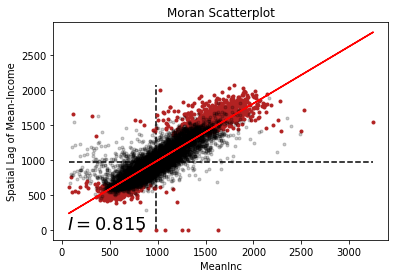

In [58]:
plt.plot(sigs, W_sigs, '.', color='firebrick')
plt.plot(insigs, W_insigs, '.k', alpha=.2)
 # dashed vert at mean of the last year's PCI
plt.vlines(mi.mean(), Lag_mi.min(), Lag_mi.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(Lag_mi.mean(), mi.min(), mi.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(mi, a + b*mi, 'r')
plt.text(s='$I = %.3f$' % I_mi.I, x=50, y=15, fontsize=18)
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Mean-Income')
plt.xlabel('MeanInc')

We can also make a LISA map of the data.

In [59]:
sig = LMo_mi.p_sim < 0.05

In [60]:
sig.sum()

4925

In [61]:
hotspots = LMo_mi.q==1 * sig

In [62]:
hotspots.sum()

1998

In [63]:
coldspots = LMo_mi.q==3 * sig

In [64]:
coldspots.sum()

2837

In [66]:
data.MeanInc[hotspots]

860      1060.904872
884      1319.604317
889      1315.246637
890      1222.786458
891      1332.968127
892      1221.244131
894      1297.653722
898      1235.882353
899      1268.181818
901      1256.020067
903      1232.142857
904      1230.914634
905      1316.745283
906      1132.042254
907      1172.241993
912      1338.568588
914      1211.054913
915      1105.806452
917      1229.713115
918      1213.704128
920      1026.757370
922      1512.834225
925      1206.549521
926      1125.851582
928      1198.092369
929      1446.996753
930      1232.132964
948      1055.906593
951      1216.322314
960      1322.972973
            ...     
10543    1228.611111
10548    1155.522088
10549    1215.358744
10556    1353.451883
10557    1107.244318
10562    1369.822006
10563    1364.668770
10564    1238.592896
10565    1481.926121
10566    1268.688119
10567    1676.336898
10568    1459.359606
10569    1297.323462
10573    1284.915014
10574    1179.954955
10576    1530.853994
10577    1468

In [67]:
data[hotspots]

,SA1_MAIN16,SA1_7DIG16,SA2_MAIN16,SA2_5DIG16,SA2_NAME16,SA3_CODE16,SA3_NAME16,SA4_CODE16,SA4_NAME16,GCC_CODE16,GCC_NAME16,STE_CODE16,STE_NAME16,AREASQKM16,OID_,SA1_2016,Workers,MeanInc,geometry
860,11501129125,1129125,115011291,11291,Baulkham Hills (West) - Bella Vista,11501,Baulkham Hills,115,Sydney - Baulkham Hills and Hawkesbury,1GSYD,Greater Sydney,1,New South Wales,1.9525,7208,1129125,521.0,1060.904872,<pysal.cg.shapes.Polygon object at 0x0000028FF...
884,11501129402,1129402,115011294,11294,Glenhaven,11501,Baulkham Hills,115,Sydney - Baulkham Hills and Hawkesbury,1GSYD,Greater Sydney,1,New South Wales,0.1757,9281,1129402,341.0,1319.604317,<pysal.cg.shapes.Polygon object at 0x0000028FF...
889,11501129407,1129407,115011294,11294,Glenhaven,11501,Baulkham Hills,115,Sydney - Baulkham Hills and Hawkesbury,1GSYD,Greater Sydney,1,New South Wales,0.1136,9255,1129407,304.0,1315.246637,<pysal.cg.shapes.Polygon object at 0x0000028FF...
890,11501129408,1129408,115011294,11294,Glenhaven,11501,Baulkham Hills,115,Sydney - Baulkham Hills and Hawkesbury,1GSYD,Greater Sydney,1,New South Wales,0.2922,8702,1129408,469.0,1222.786458,<pysal.cg.shapes.Polygon object at 0x0000028FF...
891,11501129409,1129409,115011294,11294,Glenhaven,11501,Baulkham Hills,115,Sydney - Baulkham Hills and Hawkesbury,1GSYD,Greater Sydney,1,New South Wales,0.2772,9345,1129409,327.0,1332.968127,<pysal.cg.shapes.Polygon object at 0x0000028FF...
892,11501129410,1129410,115011294,11294,Glenhaven,11501,Baulkham Hills,115,Sydney - Baulkham Hills and Hawkesbury,1GSYD,Greater Sydney,1,New South Wales,0.1491,8695,1129410,313.0,1221.244131,<pysal.cg.shapes.Polygon object at 0x0000028FF...
894,11501129412,1129412,115011294,11294,Glenhaven,11501,Baulkham Hills,115,Sydney - Baulkham Hills and Hawkesbury,1GSYD,Greater Sydney,1,New South Wales,0.3900,9158,1129412,393.0,1297.653722,<pysal.cg.shapes.Polygon object at 0x0000028FF...
898,11501129416,1129416,115011294,11294,Glenhaven,11501,Baulkham Hills,115,Sydney - Baulkham Hills and Hawkesbury,1GSYD,Greater Sydney,1,New South Wales,0.3540,8790,1129416,468.0,1235.882353,<pysal.cg.shapes.Polygon object at 0x0000028FF...
899,11501129601,1129601,115011296,11296,West Pennant Hills,11501,Baulkham Hills,115,Sydney - Baulkham Hills and Hawkesbury,1GSYD,Greater Sydney,1,New South Wales,0.4278,8998,1129601,326.0,1268.181818,<pysal.cg.shapes.Polygon object at 0x0000028FF...
901,11501129603,1129603,115011296,11296,West Pennant Hills,11501,Baulkham Hills,115,Sydney - Baulkham Hills and Hawkesbury,1GSYD,Greater Sydney,1,New South Wales,0.1479,8933,1129603,406.0,1256.020067,<pysal.cg.shapes.Polygon object at 0x0000028FF...


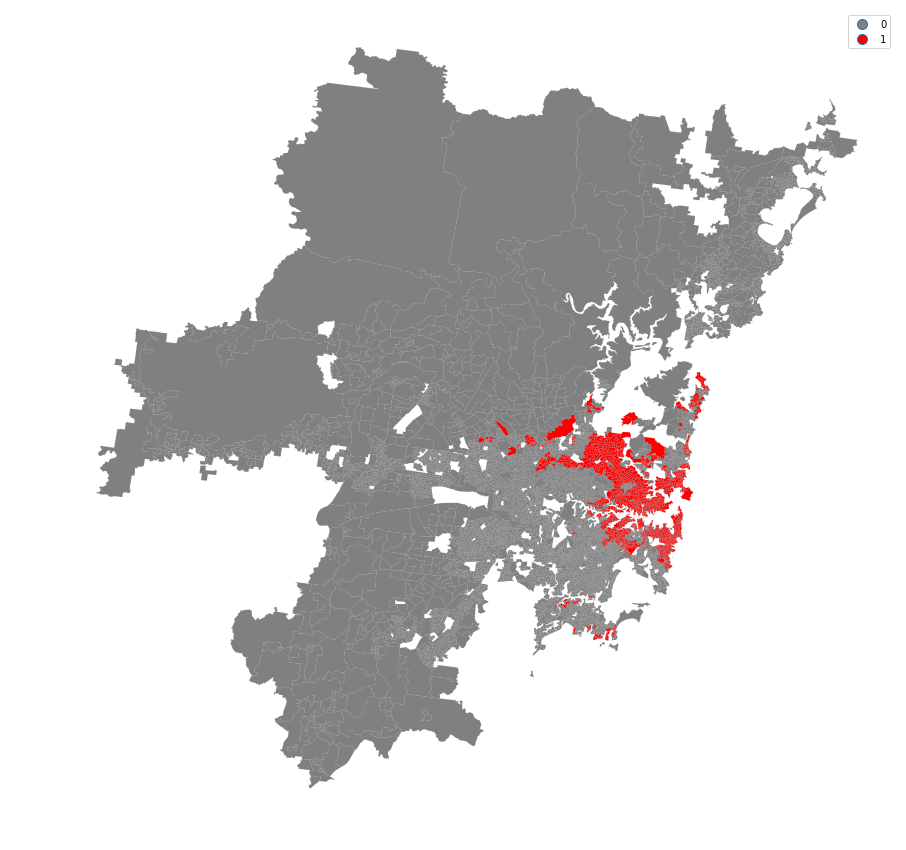

In [68]:
from matplotlib import colors
hmap = colors.ListedColormap(['grey', 'red'])
f, ax = plt.subplots(1, figsize=(15, 15))
tx.assign(cl=hotspots*1).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='grey', legend=True)
ax.set_axis_off()
plt.show()

In [69]:
data.MeanInc[coldspots]

58       527.327327
60       952.400000
62       491.666667
65       820.702006
77       793.006431
78       593.844697
80       656.185567
86       781.841652
88       911.976048
92       812.093023
96       823.920086
105      839.052288
106      619.155844
114      968.607955
116      604.187817
120      840.119363
124      704.651163
147      935.655738
170      460.248447
171      772.134670
202      859.615385
274      847.037037
281      719.634956
282      625.089286
285      804.404762
286      598.645833
287      813.496933
289      614.460285
290      791.463415
291      695.518207
            ...    
10275    591.206544
10276    424.282297
10277    527.863777
10278    551.045627
10279    505.987055
10280    683.360129
10281    529.166667
10282    547.117962
10289    958.502538
10290    833.420366
10294    869.508671
10297    761.151961
10301    554.801829
10310    826.845018
10313     93.333333
10314    833.062645
10315    879.166667
10316    688.928571
10318    720.543478


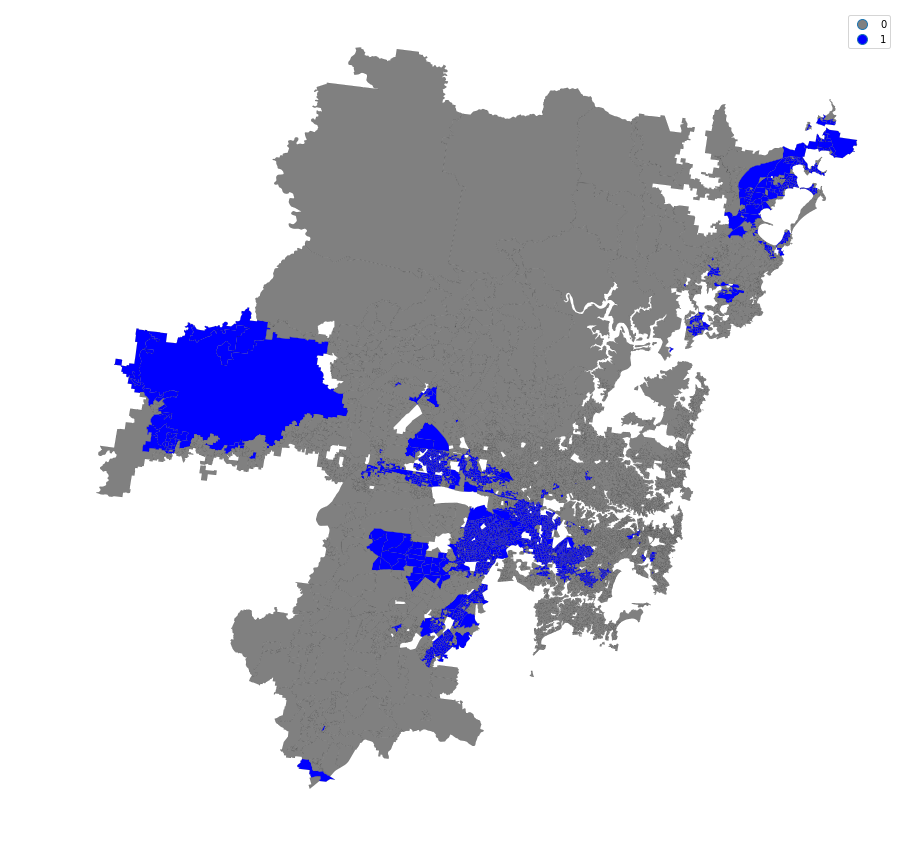

In [70]:
cmap = colors.ListedColormap(['grey', 'blue'])
f, ax = plt.subplots(1, figsize=(15, 15))
tx.assign(cl=coldspots*1).plot(column='cl', categorical=True, \
        k=2, cmap=cmap, linewidth=0.1, ax=ax, \
        edgecolor='black', legend=True)
ax.set_axis_off()
plt.show()

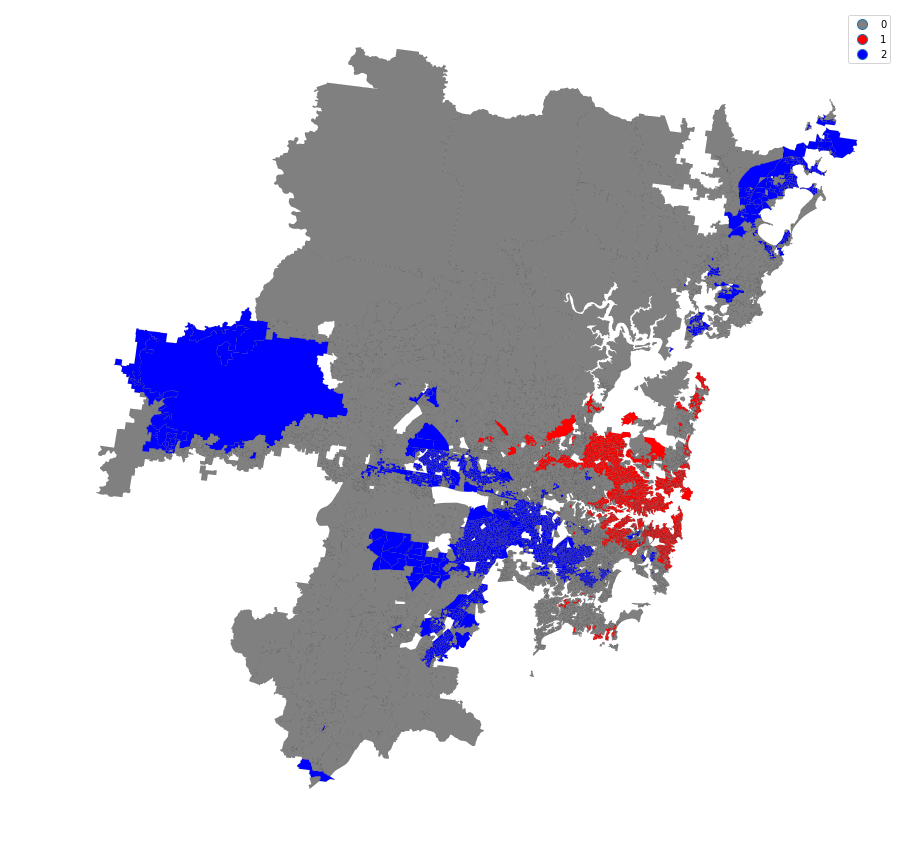

In [71]:
from matplotlib import colors
hcmap = colors.ListedColormap(['grey', 'red','blue'])
hotcold = hotspots*1 + coldspots*2
f, ax = plt.subplots(1, figsize=(15, 15))
tx.assign(cl=hotcold).plot(column='cl', categorical=True, \
        k=2, cmap=hcmap,linewidth=0.1, ax=ax, \
        edgecolor='black', legend=True)
ax.set_axis_off()
plt.show()

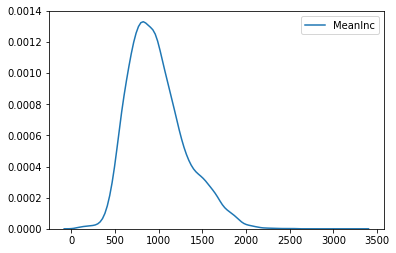

In [72]:
sns.kdeplot(data.MeanInc)

In [73]:
data.MeanInc.mean()

978.794365397436

In [74]:
data.MeanInc.median()

931.068944

Acknowledgements: This tutorial was prepared by Dr Simone Z Leao in August 2018 for the UNSW/Geocomputation course, as an adaptation from the work developed by Prof Sergio Rey (Director of PySAL Project, USA) and Dr Daniel Arribas-Bel (UK) (http://darribas.org/gds_scipy16/ipynb_md/04_esda.html). 